In [13]:
from scipy import ndimage, interpolate
import scipy.integrate as integrate
from tqdm import tqdm
from itertools import product
from copy import deepcopy
import matplotlib.pyplot as plt
from edges import edges
from dewarping import dewarp_by_lines, poly
import numpy as np
import cv2

In [10]:
def clockwise_turn_point(point, height):
    point = np.flip(point)
    point[0] = height - point[0]
    return point

def counterclockwise_turn_point(point, width):
    point = np.flip(point)
    point[1] = width - point[1]
    return point

def clockwise_90_turn(points, width, height):
    new_points = deepcopy(points)
    
    new_points = [new_points[2], new_points[0], new_points[3], new_points[1]]
    
    new_points = [clockwise_turn_point(point, height) for point in new_points]
        
    return new_points

def counterclockwise_90_turn(points, width, height):
    new_points = deepcopy(points)
    
    new_points = [new_points[1], new_points[3], new_points[0], new_points[2]]
    
    new_points = [counterclockwise_turn_point(point, width) for point in new_points]
        
    return new_points

380 (187, 500, 3)


100%|██████████| 200/200 [00:06<00:00, 31.20it/s]


380 (187, 500, 3)


100%|██████████| 200/200 [00:06<00:00, 30.64it/s]


334 (250, 374, 3)


100%|██████████| 200/200 [00:08<00:00, 22.31it/s]


334 (250, 374, 3)


100%|██████████| 200/200 [00:08<00:00, 23.02it/s]


<function matplotlib.pyplot.show(*args, **kw)>

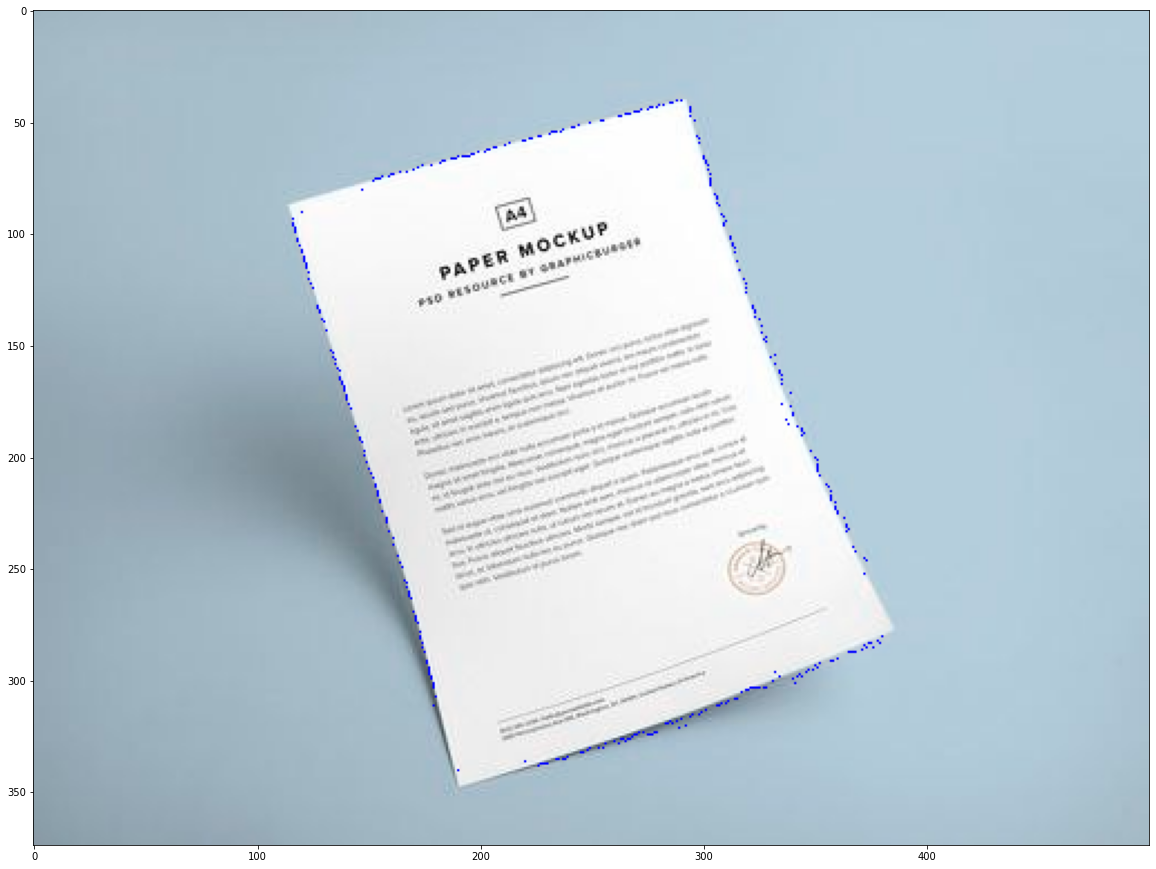

In [20]:
%reload_ext autoreload
%autoreload 2

path = 'photo_2022-04-12 16.31.37.jpeg'
image1 = cv2.imread(path, cv2.IMREAD_COLOR)

top_points = [(120,90),(290, 40)]
bottom_points = [(190, 340), (380, 280)]

width, height = image1.shape[:2][::-1]

vert_points = [np.array(top_points[0]), np.array(top_points[-1]), np.array(bottom_points[0]), np.array(bottom_points[-1])]

hor_points = clockwise_90_turn(vert_points, width, height)

top_ans, bot_ans = edges(path, vert_points, col_number=200)
left_ans, right_ans = edges(path, hor_points, col_number=200, rotation=True)
left_ans = [counterclockwise_turn_point(point, height) for point in left_ans]
right_ans = [counterclockwise_turn_point(point, height) for point in right_ans]

for point in left_ans + right_ans + top_ans + bot_ans:
    image1 = cv2.circle(image1, (int(point[0]), int(point[1])), radius=0, color=(0,0, 255), thickness=-1)
    
result = image1.astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

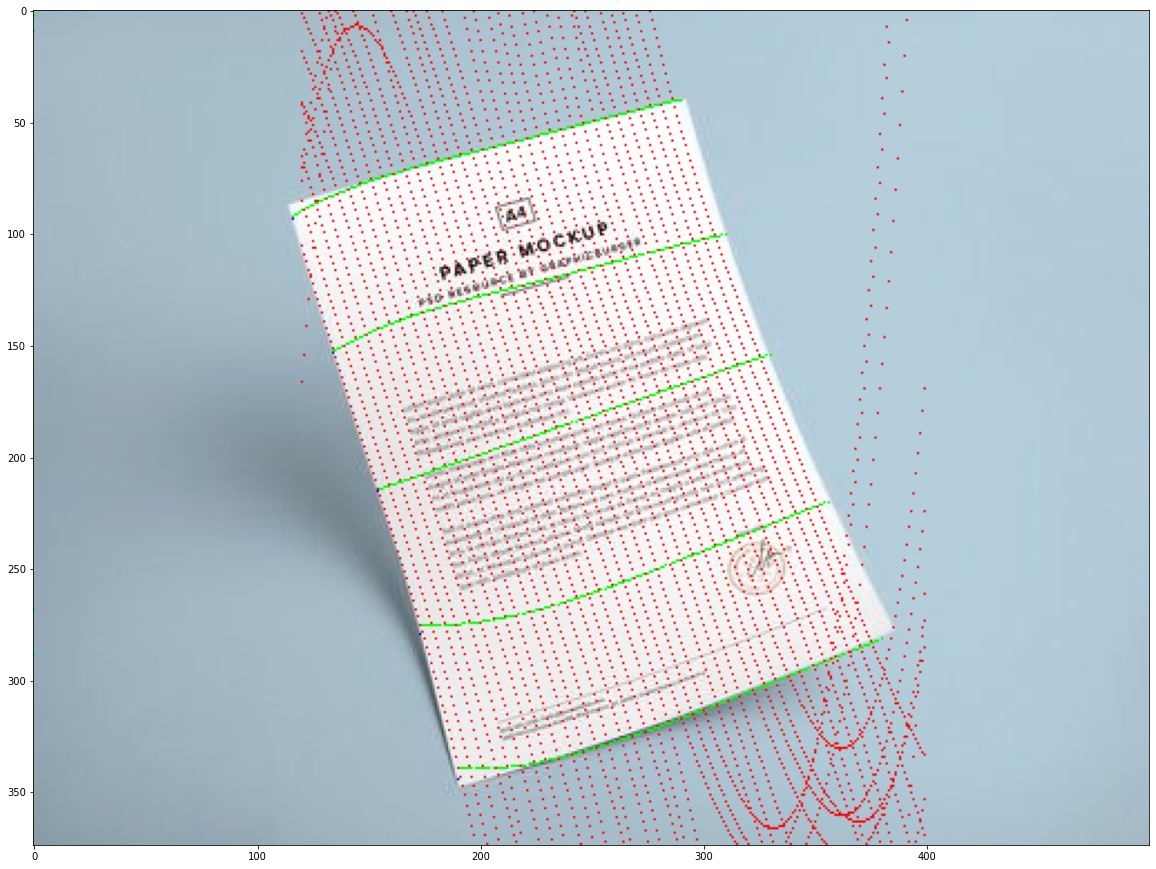

In [24]:
%reload_ext autoreload
%autoreload 2

def parts(points, num): #breaking polynom into num parts
    polynom = poly(points)
    der = np.polyder(polynom, 1)
    
    beg = min(p[0] for p in points)
    end = max(p[0] for p in points)
    
    
    calc_l = lambda y_: integrate.quad(lambda x: np.sqrt(1 + der(x) ** 2),
                                     beg, y_)[0]
    len_ = calc_l(end)
    
    ratio = lambda z : (calc_l(z) / len_)
    parts = [0 for i in range(num + 2)]
    
    cnt = 0 
    for x in range(beg, end + 1):
        cur_ratio = ratio(x)
        if cur_ratio > cnt / num:
            cnt += 1
            parts[cnt] = x
        parts[cnt] = x
        
        if cnt == num + 1:
            break
    
    return parts, polynom, len_

image1 = cv2.imread(path, cv2.IMREAD_COLOR)

l_ans, l_poly, left_len = parts(left_ans, 4)

for x in l_ans:
    image1 = cv2.circle(image1, (x, int(l_poly(x))), radius=0, color=(0,0, 255), thickness=-1)

r_ans, r_poly, right_len = parts(right_ans, 4) 

num_p = min([abs(l_ans[i] - r_ans[i]) for i in range(5)]) #number of parts to break horizontal polynoms into 

part_points = []
top_len, bot_len = 0, 0
base_points = [top_ans, [(x1 + l_ans[1] - l_ans[0], y1 + l_poly(l_ans[1]) - l_poly(l_ans[0])) for x1, y1 in top_ans],
              [np.array([l_ans[2], int(l_poly(l_ans[2]))]), np.array([r_ans[2], int(r_poly(r_ans[2]))])], 
               [(x1 - l_ans[4] + l_ans[3], y1 + l_poly(l_ans[3]) - l_poly(l_ans[4])) for x1, y1 in bot_ans], bot_ans
              ] #points to make 5 polynoms from 


for i in range(5):
    poly_ = poly(base_points[i]) 
    
    if i == 0:
        _, _, top_len = parts(top_ans, 1)
        
    if i == 4:
        poly_ = poly(bot_ans)
        _, _, bot_len = parts(bot_ans, 1)
        
    pts = []
    
    for x in range(l_ans[i], r_ans[i] + 1):
        pts.append([x, int(poly_(x))])
    
    parts_, _, _ = parts(pts, num_p)
    part_points.append([[x, int(poly_(x))] for x in parts_]) 
    for x in parts_:
        image1 = cv2.circle(image1, (x, int(poly_(x))), radius=0, color=(0,255, 0), thickness=-1)    

        
polynoms = [poly([part_points[i][j] for i in range(5)]) for j in range(num_p) ]

for i, p in enumerate(polynoms):
    if i % 5:
        continue
    for x in range(120, 400):
            image1 = cv2.circle(image1, (x, int(p(x))), radius=0, color=(255,0, 0), thickness=-1)  

result = image1.astype(np.uint8)    
plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show

177.5317334503983 255.2929840008782


100%|██████████| 178/178 [00:06<00:00, 26.57it/s]


<function matplotlib.pyplot.show(*args, **kw)>

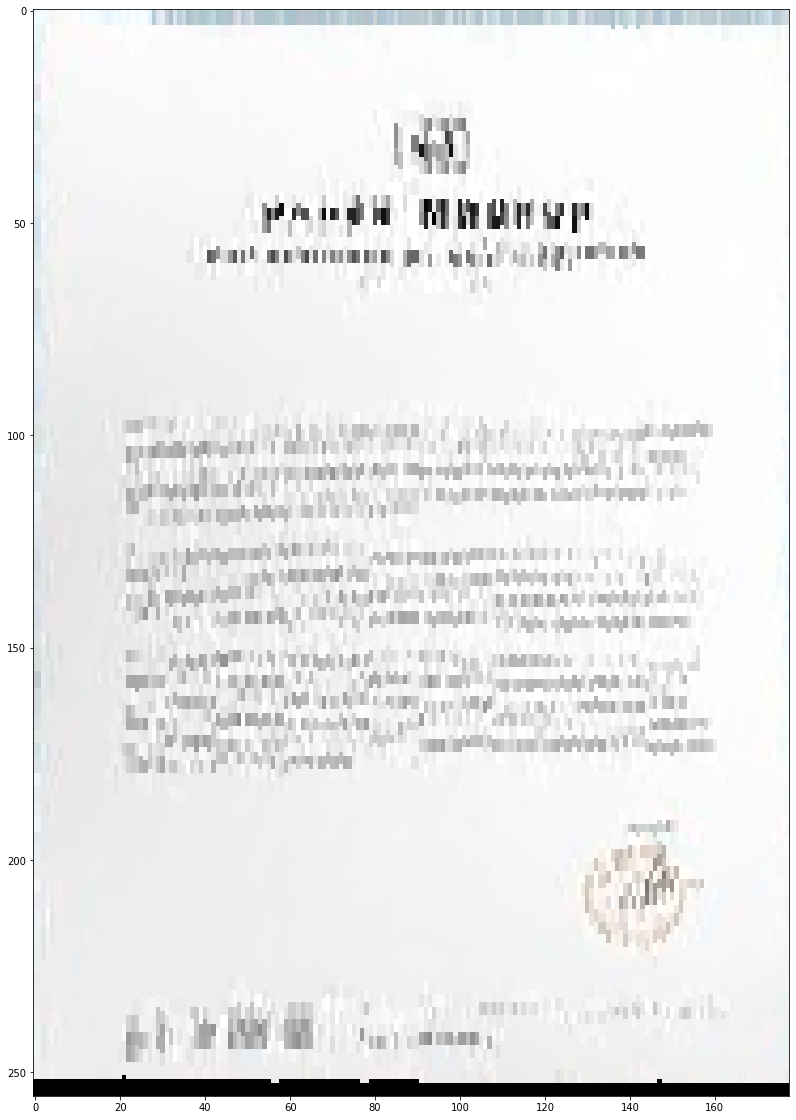

In [27]:
from tqdm import tqdm

width = min(top_len, bot_len)
height = min(left_len, right_len)

print(width, height)

w = int(part_points[0][0][0] + width + 1) - int(part_points[0][0][0])
h = int(part_points[0][0][1] + height + 1) - int(part_points[0][0][1])

final_pixels = np.zeros((h, w, 3), np.uint8)

pixels = cv2.imread(path, cv2.IMREAD_COLOR)

for x in tqdm(range(w)):
    
    poly_num = int((x / w) * num_p)
    poly_ = polynoms[poly_num]
    
    der = np.polyder(poly_, 1)
    
    calc_l = lambda y_: integrate.quad(lambda x: np.sqrt(1 + der(x) ** 2), 
                                     part_points[0][poly_num][0], y_)[0]
    
    poly_len = calc_l(part_points[4][poly_num][0])
    
    lens = {x1: calc_l(x1) for x1 in range(part_points[0][poly_num][0], part_points[4][poly_num][0])}

    
    for y in range(int(h)):
        flag = False
        
        part = y / height
        lambda_ = part / (1 - part)
        
        x1 = part_points[0][poly_num][0]
        
        for x1 in range(part_points[0][poly_num][0], part_points[4][poly_num][0]):
            if lens[x1] > poly_len * part:
                final_pixels[y][x] = pixels[int(poly_(x1 - 1))][x1 - 1]
                break


result = final_pixels.astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show   

380 (187, 500, 3)


100%|██████████| 200/200 [00:06<00:00, 31.38it/s]


380 (187, 500, 3)


100%|██████████| 200/200 [00:06<00:00, 30.31it/s]


<function matplotlib.pyplot.show(*args, **kw)>

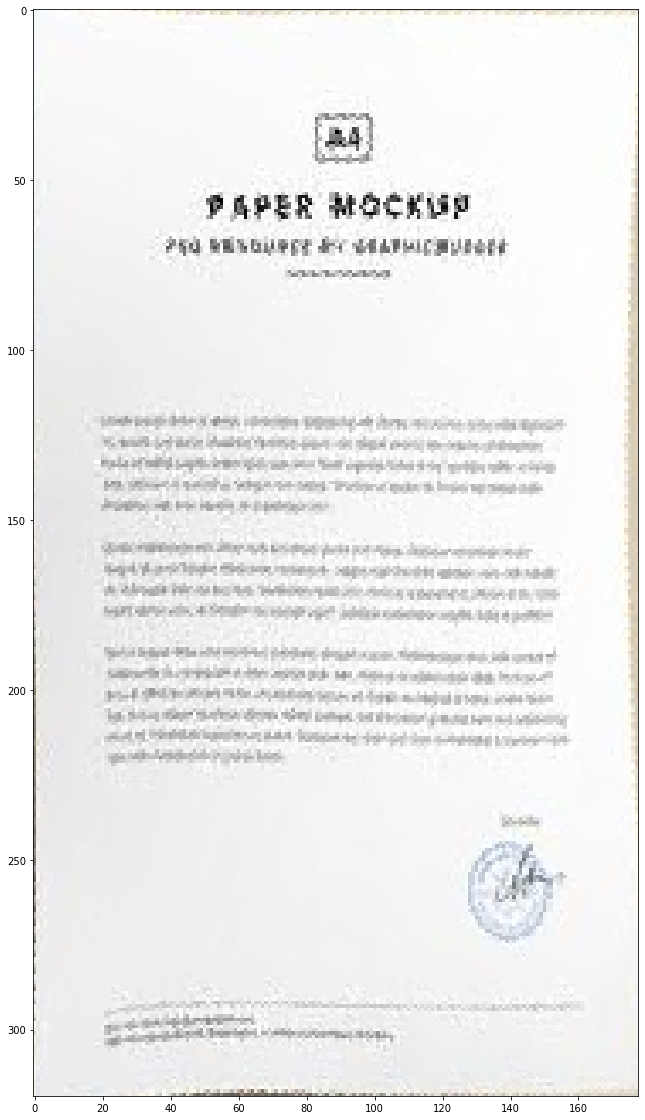

In [29]:
#vertical lines algo

from dewarping import dewarp_by_lines

path = 'photo_2022-04-12 16.31.37.jpeg'


top_points = [(120,90),(290, 40)]
bottom_points = [(190, 340), (380, 280)]


points = [np.array(top_points[0]), np.array(top_points[-1]), np.array(bottom_points[0]), np.array(bottom_points[-1])]
top_ans, bot_ans = edges(path, points, col_number = 200)

page = dewarp_by_lines(path, top_ans, bot_ans, points)

result = page.astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show